# Conditional Diffusion Generator

Andrew H. Fagg

Advanced Machine Learning


In [1]:
%reload_ext autoreload
%autoreload 2

import sys
tf_tools = "../../../../../tf_tools/"
sys.path.append(tf_tools + "experiment_control")
#sys.path.append("../hw4")

#from job_control import *
import argparse
import copy
import pickle
import random
from chesapeake_loader import *
from diffusion_tools import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Concatenate, UpSampling2D, Add
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, GlobalMaxPooling2D, Flatten, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras import Input, Model
from matplotlib import colors
from tensorflow.keras.utils import plot_model

#from gan import *
#from gan_train_loop import *

#################################################################
# Default plotting parameters
FIGURESIZE=(10,6)
FONTSIZE=18

plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

#################################################################



2024-04-23 23:28:26.494590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 23:28:26.549685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 23:28:26.549729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 23:28:26.551992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 23:28:26.565267: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Configure the GPU
visible_devices = tf.config.get_visible_devices('GPU')
for device in visible_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-04-21 14:22:26.071558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 14:22:26.096285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 14:22:26.096556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Turn off the GPU
tf.config.set_visible_devices([], 'GPU')

2024-04-23 23:28:30.507207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 23:28:30.550266: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 23:28:30.550459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
image_size=64
batch_size=8
file_base = '/home/fagg/datasets/radiant_earth/pa'
# Must match parameters used for training
timesteps = 20
beta, alpha, gamma = compute_beta_alpha(timesteps, .0001, .02, 0, 0.1)


In [4]:
# Sampling data set
ds=create_single_dataset(base_dir=file_base, 
                         full_sat=False,
                         partition='valid',
                         patch_size=image_size, 
                         fold=0,
                         cache_path=None, 
                         repeat=True, 
                         shuffle=200, 
                         batch_size=batch_size, 
                         prefetch=2, 
                         num_parallel_calls=4)


In [5]:
# Check shapes
for I, L in ds.take(1):
    print(I.shape, L.shape)

(8, 64, 64, 3) (8, 64, 64, 7)


In [6]:
# Load model
fname = 'results/unet_TESTE_filt_32_32_steps_3_sdrop_0.100_R0_model'
model = keras.saving.load_model(fname)


In [7]:
# Inference with loaded I/L
TS = list(range(timesteps))
stepdata = list(zip(TS, beta, alpha, gamma))
stepdata.reverse()
print(TS)
# Random noise
Z = np.random.normal(loc=0, scale=1.0, size=I.shape)
print("SHAPE:", Z.shape)
one = np.ones(shape=Z.shape)
zero = np.zeros(shape=Z.shape)
Zs = []

# Loop over timesteps
for ts, b, a, g in stepdata:
    Zs.append(Z)
    
    # All examples get the same time index
    t_tensor = ts * np.ones(shape=(I.shape[0], 1))

    # Predict the noise
    delta = model.predict(x={'image_input': Z, 'time_input': t_tensor, 'label_input': L})
    
    print(ts,a,b)

    # Adjust the image
    Z = Z/np.sqrt(1-b) - delta * b / (np.sqrt(1-a) * np.sqrt(1-b))

    if ts > 0:
        # Add exploratory noise
        noise = np.random.normal(loc=0, scale=1.0, size=I.shape)
        Z = Z + g * noise

# Final step
Zs.append(Z)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
SHAPE: (8, 64, 64, 3)
1/1 [==============================] - 1s 1s/step
19 0.8250560716067148 0.019005
1/1 [==============================] - 0s 302ms/step
18 0.8410400375197782 0.018009999999999998
1/1 [==============================] - 0s 312ms/step
17 0.8564649716593633 0.017015
1/1 [==============================] - 0s 237ms/step
16 0.8712899705075493 0.01602
1/1 [==============================] - 0s 244ms/step
15 0.8854752845663015 0.015025
1/1 [==============================] - 0s 222ms/step
14 0.8989824965773766 0.014029999999999999
1/1 [==============================] - 0s 225ms/step
13 0.9117746955560276 0.013035
1/1 [==============================] - 0s 251ms/step
12 0.923816645530518 0.012039999999999999
1/1 [==============================] - 0s 190ms/step
11 0.9350749479032735 0.011045
1/1 [==============================] - 0s 222ms/step
10 0.9455181963823162 0.01005
1/1 [==============================] 

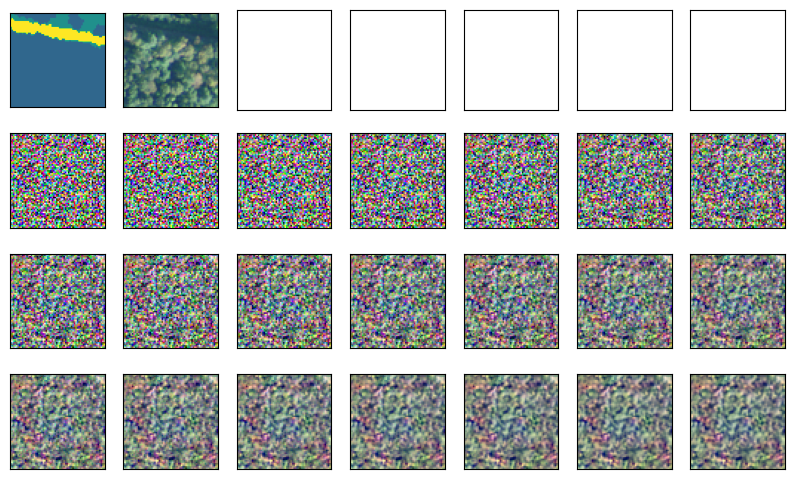

In [11]:
# Visualization
#   You will need to play with this

i=1
cols = 7
fig, axs = plt.subplots(timesteps//cols+2, cols)

cl = np.argmax(L[i,:,:,:], axis=-1)
axs[0,0].imshow(cl, vmax=6, vmin=0)
axs[0,1].imshow(I[i,:,:,:])

for j in range(cols):
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])


for j, Z in enumerate(Zs):
    axs[j//cols+1, j%cols].imshow(convert_image(Z[i,:,:,:]))
    axs[j//cols+1, j%cols].set_xticks([])
    axs[j//cols+1, j%cols].set_yticks([])



In [10]:
gamma

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095])